In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('csv',data_files='dataset_semanticattribution_nerfeatures_split.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","gold_exp","gem_exp","gem_label","entity_map_ev","entity_ev","split"],skiprows=1)

Using custom data configuration default-056e0caec74e8696
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-056e0caec74e8696/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 222.21it/s]


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_exp', 'gem_exp', 'gem_label', 'entity_map_ev', 'entity_ev', 'split'],
        num_rows: 2322
    })
})

In [4]:
dataset['train']['split']

['train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'validation',
 'train',
 'validation',
 'validation',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'test',
 'validation',
 'test',
 'validation',
 'train',
 'validation',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'test',
 'validation',
 'train',
 'validation',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'validation',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'valida

In [5]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-056e0caec74e8696/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-2a2c42dfce2e5962.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-056e0caec74e8696/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-30c3c2aed9ee6058.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-056e0caec74e8696/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-2aa654a7b533269e.arrow


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_exp', 'gem_exp', 'gem_label', 'entity_map_ev', 'entity_ev', 'split'],
        num_rows: 1623
    })
    val: Dataset({
        features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_

In [7]:
columns_to_keep = ['claim', 'premise', 'label','category','count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat','counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat']
all_columns = train_dataset.column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [8]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 1,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)

# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-056e0caec74e8696/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-028471e2a2bfb5ad.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-056e0caec74e8696/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-0344ef8596cd0df0.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-056e0caec74e8696/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-14ae10d3bdd00042.arrow


Label Encoding Mapping: {'contradiction': 1, 'entailment': 0, 'neutral': 1}


In [9]:
labels = np.array(dataset['train']['label'])

In [10]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='MoritzLaurer/DeBERTa-v3-base-mnli-fever-docnli-ling-2c'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts
        category = item['category']

        claim = item['claim'].lower() + "[" + category + "]"
        premise = item['premise'].lower().replace('\n', '').replace('[','').replace(']','')
        
        additional_features = [
            "count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
    
        for feature in additional_features:
            if feature in item:
                claim += "[SEP]" + str(item[feature])
        
        additional_features_ev = [
            'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat']
    
        for feature_ev in additional_features_ev:
            if feature_ev in item:
                premise += "[SEP]" + str(item[feature])
        item['claim']=claim
        item['premise']=premise        
        # Tokenize the texts
        inputs = self.tokenizer(
             premise, claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': premise  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item

In [11]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [12]:
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-docnli-ling-2c"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=2, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    bal_accuracy = balanced_accuracy_score(labels,preds)

    return {"accuracy": acc, "balanced_accuracy":bal_accuracy, "precision": prec, "recall": recall, "f1": f1}

In [14]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat'],
    num_rows: 1623
})

In [15]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [16]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [17]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [18]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [19]:
tdata.__getitem__(0)

{'input_ids': tensor([     1,   2600,   1655,  16876,    667,  15726,  61593,    261,   2030,
            260,    346,  15302,   6848,  15726,  61593,    261,    584,    260,
            346,  33770,    452,  15726,  61593,  16876,    667,  15726,  61593,
            261,    845,    260,    346,  14033,   2179,  24360,  34984,  15726,
          61593,    261,   1917,    260,    346,  51194,  73907,   8007,  15726,
          61593,    261,   2673,    260,    346,   1942,   3359,  73907,   8007,
          15726,  61593,    261,   4402,    260,  88609,    263,  98237,   1830,
           6725,    263,   5134,  30055,  77487,    532,   4014,    271,    547,
          52263,  16224,    265,  86207,  14178,    268,    260,  62713,   4379,
            261,    584,    260,  41529,  23399,    429,   8068,   1068,    268,
            265,  42543,    834,   1917, 110269,    287,    260, 116367,   2148,
            263,  25348,  20413,   1563,    265,    917,    263,    308,    266,
          84530

In [20]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/5.2.5_deberta_docnli/',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.06,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/5.2.5_deberta_docnli/best_model')
tokenizer.save_pretrained(f'/home/elson/5.2.5_deberta_docnli/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1530


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.508300,0.595460,0.737634,0.684578,0.729775,0.737634,0.731940
2,0.359600,0.647949,0.737634,0.719551,0.747774,0.737634,0.741339
3,0.269100,0.821429,0.731183,0.714744,0.743251,0.731183,0.735435
4,0.107700,1.186982,0.763441,0.732120,0.763441,0.763441,0.763441
5,0.137500,0.954238,0.748387,0.695921,0.740840,0.748387,0.742635
6,0.049800,1.476530,0.735484,0.739599,0.763947,0.735484,0.742320
7,0.004500,2.046816,0.701075,0.700635,0.730530,0.701075,0.708801
8,0.005300,2.145291,0.718280,0.720117,0.747239,0.718280,0.725560
9,0.000100,2.124743,0.750538,0.735828,0.761524,0.750538,0.754345
10,0.000300,2.298436,0.741935,0.731083,0.756801,0.741935,0.746691


***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/5.2.5_deberta_docnli/checkpoint-102
Configuration saved in /home/elson/5.2.5_deberta_docnli/checkpoint-102/config.json
Model weights saved in /home/elson/5.2.5_deberta_docnli/checkpoint-102/pytorch_model.bin
Deleting older checkpoint [/home/elson/5.2.5_deberta_docnli/checkpoint-1122] due to args.save_total_limit
Deleting older checkpoint [/home/elson/5.2.5_deberta_docnli/checkpoint-1530] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/5.2.5_deberta_docnli/checkpoint-204
Configuration saved in /home/elson/5.2.5_deberta_docnli/checkpoint-204/config.json
Model weights saved in /home/elson/5.2.5_deberta_docnli/checkpoint-204/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/5.2.5_deberta_docnli/checkpoint-306
Configura

Configuration saved in /home/elson/5.2.5_deberta_docnli/best_model/config.json
Model weights saved in /home/elson/5.2.5_deberta_docnli/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/5.2.5_deberta_docnli/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/5.2.5_deberta_docnli/best_model/special_tokens_map.json
added tokens file saved in /home/elson/5.2.5_deberta_docnli/best_model/added_tokens.json


('/home/elson/5.2.5_deberta_docnli/best_model/tokenizer_config.json',
 '/home/elson/5.2.5_deberta_docnli/best_model/special_tokens_map.json',
 '/home/elson/5.2.5_deberta_docnli/best_model/spm.model',
 '/home/elson/5.2.5_deberta_docnli/best_model/added_tokens.json')

In [21]:
model_path = "/home/elson/5.2.5_deberta_docnli/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/5.2.5_deberta_docnli/best_model/config.json
Model config DebertaV2Config {
  "_name_or_path": "/home/elson/5.2.5_deberta_docnli/best_model/",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "not_entailment"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "entailment": 0,
    "not_entailment": 1
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention

In [22]:
print(test_results)

PredictionOutput(predictions=array([[ 1.912 , -1.824 ],
       [ 3.521 , -3.354 ],
       [ 3.363 , -3.195 ],
       [-3.568 ,  3.732 ],
       [ 1.161 , -1.107 ],
       [ 4.02  , -3.814 ],
       [ 3.979 , -3.781 ],
       [ 4.402 , -4.164 ],
       [ 3.506 , -3.336 ],
       [ 0.2537, -0.2386],
       [ 4.21  , -3.99  ],
       [ 4.383 , -4.152 ],
       [-2.748 ,  2.95  ],
       [ 4.375 , -4.14  ],
       [ 3.768 , -3.582 ],
       [-2.105 ,  2.295 ],
       [ 3.797 , -3.611 ],
       [ 3.594 , -3.418 ],
       [ 4.418 , -4.184 ],
       [ 4.004 , -3.803 ],
       [-0.4023,  0.3967],
       [ 2.969 , -2.826 ],
       [ 2.84  , -2.72  ],
       [-3.246 ,  3.43  ],
       [ 2.664 , -2.553 ],
       [-3.584 ,  3.748 ],
       [ 4.383 , -4.15  ],
       [ 3.623 , -3.445 ],
       [ 4.195 , -3.979 ],
       [ 4.477 , -4.234 ],
       [ 0.788 , -0.759 ],
       [ 3.986 , -3.787 ],
       [ 3.48  , -3.314 ],
       [ 2.639 , -2.525 ],
       [ 2.441 , -2.322 ],
       [ 3.844 , -3.656 ],

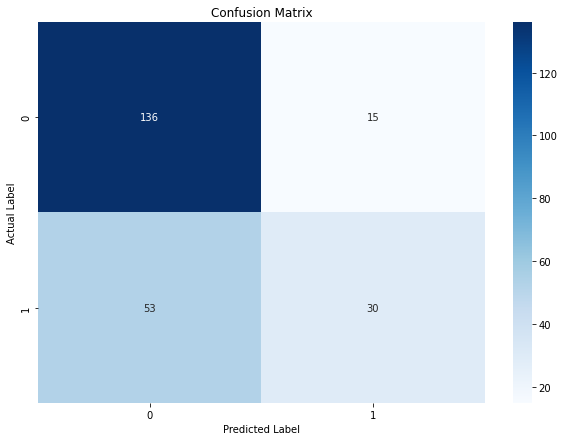

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [24]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/5.2.5_results.csv', index=False)

In [25]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [26]:
correct_classification_counts

General Health           37
Bone health              15
Cancer                   12
Diabetes                 11
Cardiovascular Health    11
Fitness                  10
Throat                    9
Neurological health       9
Skin                      8
COVID                     6
Ear                       6
Hair                      6
Eye                       6
Women' s Health           5
Muscles                   5
Blood                     4
Men's health              3
Mental Health             2
Vascular                  1
Name: Category, dtype: int64

In [27]:
misclassification_counts

Skin                     16
General Health           14
Bone health               6
Hair                      6
Fitness                   5
Blood                     5
Eye                       3
Men's health              3
Dental Health             3
Vascular                  2
Diabetes                  1
Mental Health             1
Women' s Health           1
Muscles                   1
Cardiovascular Health     1
Name: Category, dtype: int64

In [28]:
total_counts = df['Category'].value_counts()

# Calculate ratios
correct_classification_ratios = correct_classification_counts / total_counts
misclassification_ratios = misclassification_counts / total_counts

In [29]:
print(correct_classification_ratios)

Blood                    0.444444
Bone health              0.714286
COVID                    1.000000
Cancer                   1.000000
Cardiovascular Health    0.916667
Dental Health                 NaN
Diabetes                 0.916667
Ear                      1.000000
Eye                      0.666667
Fitness                  0.666667
General Health           0.725490
Hair                     0.500000
Men's health             0.500000
Mental Health            0.666667
Muscles                  0.833333
Neurological health      1.000000
Skin                     0.333333
Throat                   1.000000
Vascular                 0.333333
Women' s Health          0.833333
Name: Category, dtype: float64


In [30]:
print(misclassification_ratios)

Blood                    0.555556
Bone health              0.285714
COVID                         NaN
Cancer                        NaN
Cardiovascular Health    0.083333
Dental Health            1.000000
Diabetes                 0.083333
Ear                           NaN
Eye                      0.333333
Fitness                  0.333333
General Health           0.274510
Hair                     0.500000
Men's health             0.500000
Mental Health            0.333333
Muscles                  0.166667
Neurological health           NaN
Skin                     0.666667
Throat                        NaN
Vascular                 0.666667
Women' s Health          0.166667
Name: Category, dtype: float64
